In [1]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import os
import numpy as np
import nltk
import re
import seaborn as sns
import pandas as pd
from nltk.text import TextCollection
from collections import Counter
from numpy.random import choice
from nltk.corpus import webtext
from nltk import word_tokenize, sent_tokenize
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score,train_test_split

# Modèle vectoriel

---

*   Extraire le vocabulaire utilisé par un ensemble de documents



In [7]:
# load texts&extract vocabulary
nltk.download('punkt')
from nltk.corpus import gutenberg

for fileid in gutenberg.fileids():
  chars = gutenberg.raw(fileid)
  words = gutenberg.words(fileid)
  sents = gutenberg.sents(fileid)
  vocab = set(w.lower() for w in gutenberg.words(fileid))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


*  Calculez l'idf de chaque terme



In [8]:
corpus = TextCollection(sents)

mot_idf = []
for mot in words:
  mot_idf.append(corpus.idf(mot))

* Fournir une représentation vectorielle de chacun des documents précédents basé sur le vocabulaire extrait. Utilisez différents schéma de pondération (tf, wf, tf−idf, wf−idf...)


In [9]:
vocab_wf = CountVectorizer().fit_transform(vocab)
vocab_tfidf = TfidfTransformer().fit_transform(vocab_wf)
vocab_tf = TfidfTransformer(use_idf=False).fit_transform(vocab_wf)

* Proposez les 10 premiers documents d'une liste ordonnée sur la base d'un score de correspondance entre requête et document.

In [10]:
doc_ord=nltk.ConditionalFreqDist((target,fileid[:10]) for fileid in gutenberg.fileids() for w in gutenberg.words(fileid) for target in ['america','citizen'] if w.lower().startswith(target))

In [11]:
doc_ord

ConditionalFreqDist(nltk.probability.FreqDist,
                    {'america': FreqDist({'bryant-sto': 3,
                               'chesterton': 36,
                               'melville-m': 53,
                               'milton-par': 1,
                               'whitman-le': 93}),
                     'citizen': FreqDist({'austen-emm': 1,
                               'bible-kjv.': 3,
                               'chesterton': 16,
                               'edgeworth-': 1,
                               'shakespear': 2,
                               'whitman-le': 4})})

# Modèle de langue

A partir d'un corpus de documents estimez les modèles probabilistes :

*   unigramme P(t)
*   bigramme P(ti|tj)

Et générez des séquences de termes issues de ces modèles.

In [12]:
def generate_model(cfdist,word,num=5):
    for i in range(num):
        print(word)
        word=cfdist[word].max()
bigrams = nltk.bigrams(words)
cfd=nltk.ConditionalFreqDist(bigrams)
generate_model(cfd,'what')

what
is
the
earth
,


In [13]:
def unigram_prob_map(unigram_counter):
  n_words = sum(unigram_counter.values())
  return {w: unigram_counter[w]/float(n_words) for w in unigram_counter}

def generate(vocab, start_words, n_words):
  # Create probability map
  unigram_counter = Counter(vocab)
  unigram_prob = unigram_prob_map(unigram_counter)

  # Build sentence
  w1, w2 = start_words[0], start_words[1]
  words = [w1, w2]
  for i in range(n_words):
    # Use unigram
    prob_map = unigram_prob
    next_words = prob_map.keys()
    next_word = choice(next_words, p=[prob_map[w] for w in next_words])

    # Update words
  w1 = w2
  w2 = next_word
  words.append(w2)
  sentence = ' '.join(words)
  return sentence 

In [17]:
s = generate(vocab,['hi','i'],2)

ValueError: ignored

# Classification de texte



*   Sélectionnez plusieurs ressources textuelles (par exemple différents ouvrages de nltk) et découpez chacune d'elles en phrase.

*   Utilisez les différentes ressources textuelles comme des classes et les phrases comme des éléments associés à ces classes.



In [96]:
nltk.download('webtext')

data = pd.DataFrame()
X_train = pd.DataFrame()
i = 0
for fileid in webtext.fileids():
  temp = sent_tokenize(webtext.raw(fileid))
  temp = pd.DataFrame(temp)
  temp['class'] = i
  i += 1
  data = pd.concat([X_train,temp],axis=0)

[nltk_data] Downloading package webtext to /root/nltk_data...
[nltk_data]   Package webtext is already up-to-date!


In [98]:
nltk.download('nps_chat')

i = 0
for fileid in nps_chat.fileids():
  temp = sent_tokenize(nps_chat.raw(fileid))
  temp = pd.DataFrame(temp)
  temp['class'] = i
  i += 1
  data = pd.concat([X_train,temp],axis=0)

[nltk_data] Downloading package nps_chat to /root/nltk_data...
[nltk_data]   Unzipping corpora/nps_chat.zip.




*   Proposez des méthodes de classification de texte, que vous évaluerez sur votre corpus après l'avoir partitionné en base d'apprentissage, base de validation et base de test.

In [100]:
from sklearn.model_selection import train_test_split
X = data.iloc[:,0]
y = data.iloc[:,1]
X.replace(',', "")
X.replace("'", "")
X.replace('.', "")
X.replace('"', "")
X.replace('?', '')
X.replace('!', "")
X.replace(':', '')
X.replace('\n', '')
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2)

In [101]:
# Create document vectors
vectorizer = CountVectorizer(max_features=3000)
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_test_counts = vectorizer.transform(X_test)

tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

In [103]:
# train a Naive Bayes classifier using tf_idf
clf_2 = MultinomialNB()
clf_2.fit(X_train_tf, y_train)
y_test_pred = clf_2.predict(X_test_tf)
from sklearn.metrics import accuracy_score
test_tf_score = accuracy_score(y_test, y_test_pred)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


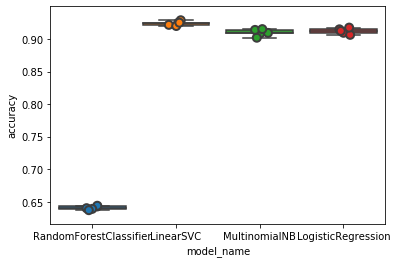

In [ ]:
models = [RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
          LinearSVC(),
          MultinomialNB(),
          LogisticRegression(random_state=0)]

CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, X_transform, y, scoring='accuracy', cv=CV)
  
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()



In [ ]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.923944
LogisticRegression        0.911997
MultinomialNB             0.909671
RandomForestClassifier    0.640798
Name: accuracy, dtype: float64


*   Sélectionnez la méthode offrant les meilleures performances sur votre base de validation (éventuellement en utilisant de la cross-validation) et donnez ses performances (matrice de confusion) sur la base de test.

In [ ]:
model = LinearSVC()
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X_transform, y, data.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
def plot_conf_mat(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    CLASSES_LIST = np.unique(y_test)
    print(conf_mat)
    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, title='Confusion matrix, without normalization')
    plt.subplot(122)
    plot_confusion_matrix(conf_mat, CLASSES_LIST, normalize=True, title='Normalized confusion matrix')
    plt.show()


[[ 367    2   20    1    0    5]
 [   0  401  210    5    0    7]
 [   0   28 5751   22    1   55]
 [   0    9  162  307    0   11]
 [   0    0   25    1   66    7]
 [   0    0   99    4    0 1798]]
Confusion matrix, without normalization
Normalized confusion matrix


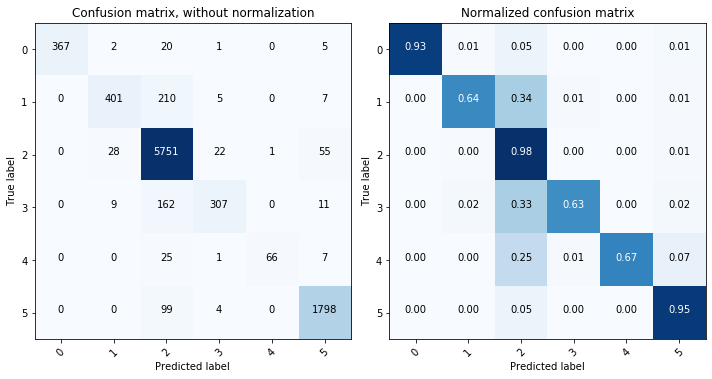

In [ ]:
plot_conf_mat(y_test,y_pred)